In [1]:
# [1]
# 패키지 및 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

In [2]:
# [2]
# 텐서플로우 버전 낮추기
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# [3]
# 난수의 시드를 설정
np.random.seed(1871063)
tf.set_random_seed(1871063)

In [4]:
# [4]
# 학습 데이터를 생성하기
def generate_datablock(n, mu, var, t):
  data = multivariate_normal(mu, np.eye(2)*var, n)
  df = DataFrame(data, columns=['x1', 'x2'])
  df['t'] = t
  return df

df0 = generate_datablock(1500, [7,7], 22, 1)
df1 = generate_datablock(1500, [22,7], 22, 0)
df2 = generate_datablock(1500, [7,22], 22, 1)
df3 = generate_datablock(1500, [22,22], 22, 0)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [5]:
# [5]
# 학습 데이터 확인하기
train_set

,x1,x2,t
0,24.447969,-0.255650,0
1,0.318750,18.969677,1
2,5.003942,29.348797,1
3,24.196732,2.784695,0
4,1.402994,5.772093,1
...,...,...,...
5995,9.966946,21.207892,1
5996,24.294832,15.221411,0
5997,24.745872,5.835662,0
5998,21.693257,18.405533,0


In [6]:
# [6]
# (x1, x2)와 t를 각각 모은 것을 NumPy의 array 오브젝트로 추출해둔다

train_x = train_set[['x1', 'x2']].to_numpy()
train_t = train_set['t'].to_numpy().reshape([len(train_set),1])

In [7]:
# [7]
# 단층 신경망을 이용한 이항 분류기 모델을 정의한다.

num_units = 2000
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
# hidden1 = tf.nn.relu(tf.matmul(x,w1) + b1*mult)
hidden1 = tf.nn.tanh(tf.matmul(x,w1) + b1*mult)

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

In [8]:
p.shape

TensorShape([Dimension(None), Dimension(1)])

In [9]:
# [8]
# 오차 함수 loss, 트레이닝 알고리즘 train_step, 정답률 accuracy를 정의한다.

t = tf.placeholder(tf.float32, [None,1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.000001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
# [9]
# 세션을 준비하고 Variable을 초기화한다.

sess = tf.InteractiveSession()        # tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
# [10]
# 파라미터 최적화를 1000회 반복한다.

i = 0
for _ in range(3000):
  i += 1
  sess.run(train_step, feed_dict={x:train_x, t:train_t})
  if i % 100 == 0:
    loss_val, acc_val = sess.run(
        [loss, accuracy], feed_dict={x:train_x, t:train_t})
    print('Step: %d, Loss: %f, Accuracy: %f'
          % (i, loss_val, acc_val))

Step: 100, Loss: 2382.961914, Accuracy: 0.808333
Step: 200, Loss: 2106.726074, Accuracy: 0.830833
Step: 300, Loss: 1747.264160, Accuracy: 0.878167
Step: 400, Loss: 1416.739258, Accuracy: 0.914333
Step: 500, Loss: 1195.561157, Accuracy: 0.930167
Step: 600, Loss: 1064.530640, Accuracy: 0.936667
Step: 700, Loss: 987.622131, Accuracy: 0.940000
Step: 800, Loss: 941.188354, Accuracy: 0.943500
Step: 900, Loss: 912.050293, Accuracy: 0.945000
Step: 1000, Loss: 893.041199, Accuracy: 0.945167
Step: 1100, Loss: 880.194458, Accuracy: 0.945167
Step: 1200, Loss: 871.234741, Accuracy: 0.945000
Step: 1300, Loss: 864.804565, Accuracy: 0.945000
Step: 1400, Loss: 860.064758, Accuracy: 0.946000
Step: 1500, Loss: 856.481079, Accuracy: 0.946000
Step: 1600, Loss: 853.704834, Accuracy: 0.945500
Step: 1700, Loss: 851.504028, Accuracy: 0.945833
Step: 1800, Loss: 849.721741, Accuracy: 0.946000
Step: 1900, Loss: 848.249756, Accuracy: 0.946333
Step: 2000, Loss: 847.012695, Accuracy: 0.946333
Step: 2100, Loss: 845.9

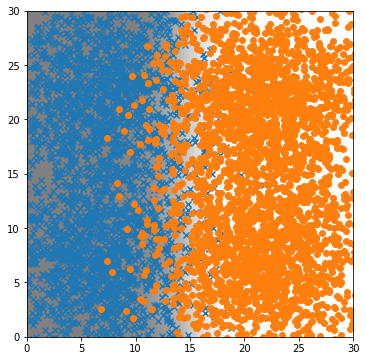

In [12]:
# [11]
# 얻어진 확률을 색의 농담으로 그림에 표시한다.

train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_ylim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
  for x1 in np.linspace(0,30,100):
    locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)